# Psuedo-Surge Simulation of Synthetic Little Kluane  


Before we figure out the best way to prescribe sliding in `Elmer` let's first take some time to understand how sliding in prescribed in `Elmer`. 
In `Elmer/Ice` the default sliding law is of the form: 
$$
\tau = \beta^2 u
$$
where $\tau$ is traction (i.e. basal shear stress), $u$ is velocity in the tangetial plane, and $\beta^{-2}$ is the slip coefficent. Let's use some example values from Cuffey and Patterson to look into units, and how we will need to scale to `Elmer/Ice` base units of MPa, a, m. 
Note, Cuffey and Patterson use a simpler measure of lubrication with an apparent drag factor, $\psi$, a positive number
defined by
$$
\tau_b = \psi u_b
$$
for a basal shear stress $\tau_b$, and rate of slip $u_b$.
Values listed below come from Table 7.2 in Cuffey and Patterson

|    Glacier    | $\tau_b$ <br>(kPa) | $u_b$ <br>(m y$^{-1}$) | $\psi$<br>(kPa (m y$^{-1}$)$^{-1}$) |
|:-------------:|:------------------:|:----------------------:|:-----------------------------------:|
|   Trapridge   |         80         |           30           |        $\approx$ 3                  |
| Storglaciären |         40         |           30           |        $\approx$ 1                  |

So, let's begin by scaling these example parameter values to `Elmer/Ice` base units (MPa, a, m): 

|    Glacier    | $\tau_b$ <br>(MPa) | $u_b$ <br>(m y$^{-1}$) | $\psi$<br>(MPa (m y$^{-1}$)$^{-1}$) |
|:-------------:|:------------------:|:----------------------:|:-----------------------------------:|
|   Trapridge   |         8e-2       |           30           |       $\approx$ 3e-3                |
| Storglaciären |         4e-2       |           30           |       $\approx$ 1e-3                |


Great! Now we can see from these two simple formulations: 
$$
\beta = \sqrt{\psi}
$$

Let's use our inital conditions (i.e. $z_s$ and $z_b$) to figure out the corresponding value of $\beta$ for some set value of $u_b$. To do this we will need to make an approximation of $\tau_b$ using the approximation: 

$$
\tau_b = \rho g H \sin \alpha
$$

where $\rho$ is the ice density, $g$ is the acceleration due to gravity, and $\alpha$ is the suface slope. 

First, lets make sure our units are going to be correct during these back of the envelope calculations: 

In [1]:
import pint 
import numpy as np 
import matplotlib.pyplot as plt 

plt.rcParams['text.usetex'] = True

ureg = pint.UnitRegistry()

#############################################
# units
#############################################
a   = ureg.year             # [a]
s   = ureg.sec              # [s]
m   = ureg.meter            # [m]
kg  = ureg.kilogram         # [kg]
kPa = ureg('kPa')           # [kPa]
MPa = ureg('MPa')           # [MPa]

#############################################
# parameters (S.I. units)
#############################################
spy   = 365.25*24*60*60 * (s/a)                    # [s a^-1]
ρ     = 910             * (kg*m**-3)               # [Kg m^-3]
g     = 9.81            * (m*s**-2)                # [m s^-2]

#############################################
# parameters (Elmer/Ice)
#############################################
ρ     = ρ * (MPa/MPa.to_base_units()) * spy**-2    # [MPa m^-2 a^2] <--[Kg m^-3]
g     = g * spy**2                                 # [m a^-2] <--------[m s^-2]

Great. Let's now read in our inital conditions and assign the appropraite units: 

In [2]:
x_c = np.loadtxt('../Data/Topography/REF_SurfTopo.dat')[:,0]    # x-coordinate
z_s = np.loadtxt('../Data/Topography/REF_SurfTopo.dat')[:,1]    # surface elevation (m a.s.l.)
z_b = np.loadtxt('../Data/Topography/REF_BedTopo.dat')[:,1]     # bed evelation (m a.s.l.)

H      = (z_s - z_b) * m                         # Ice thickness (m)
α      = np.zeros_like(H) * m/m                  # Surface slope (m/m)
# Surface slope only valid where H>0
α[H>0] = np.gradient(z_s[H>0], x_c[H>0])         

Now let's solve for the approximation of the basal shear stress ($\tau_b$) for "synthetic" little Kluane 

In [3]:
# Approximation of the basal shear stress for LK
𝜏 = ρ*g*H*np.sin(α)

Now let's solve for the $\beta$ corresponding to $u_b$ = 365 (m a$^{-1}$) or 1 (m d$^{-1}$). 

In [4]:
β_sqaured = 𝜏 / (365. * m /a)

In [5]:
np.mean(β_sqaured[β_sqaured>0.0])

0.00029698127135406924 <Unit('megapascal * year / meter')>

In [8]:
np.sqrt(1 / 3.5e-4)

53.45224838248488

---------
# Spectral Bed Characteristics 

Following [Gudmundsson 2003](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2002JB002107), let's define our bed $z_{\rm b}$ as: 

$$
z_{\rm b}(x) = z_{\rm b_{\rm F}} + z_{\rm b}'
$$

where $z_{\rm b}$ is synthetic bed profile as a function of distance along the flowline, $z_{\rm b_{\rm F}}$ is the observed Farinotti bed (in this case smoothed), and $z_{\rm b}'$ is our pertubation. 

Pertubations will take the form:
$$
z_{\rm b}' = \sum_{k=1}^{10} A_{k} \sin \left( \frac{2 \pi}{k \bar H} x \right)
$$
where, $A_{k}$ is amplitude of the $k$-th harmonic and $\bar H$ is the mean ice-thickness. 

In [7]:
len(x_c)

284

In [58]:
#fig_fp = "../plots/spectral/{}"

from scipy import interpolate

x_c = np.loadtxt('../Data/Topography/REF_SurfTopo_2.dat')[:,0]    # x-coordinate
z_s = np.loadtxt('../Data/Topography/REF_SurfTopo_2.dat')[:,1]    # surface elevation (m a.s.l.)
z_b = np.loadtxt('../Data/Topography/REF_BedTopo_2.dat')[:,1]     # bed evelation (m a.s.l.)

func = interpolate.interp1d(x_c, z_b)

x_c = np.linspace(0,x_c[-1],557)
z_b = func(x_c)

Text(0.5, 0, 'x-coord (m)')

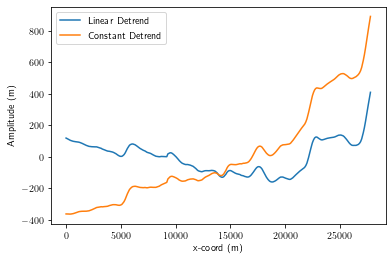

In [60]:
trend = np.polyval(np.polyfit(x_c, z_b, 1), x_c)

fig, ax = plt.subplots()
ax.plot(x_c, z_b-trend, label='Linear Detrend')
ax.plot(x_c, z_b-z_b.mean(), label='Constant Detrend')
ax.legend()

ax.set_ylabel('Amplitude (m)')
ax.set_xlabel('x-coord (m)')

#fig.savefig(fig_fp.format('00_detrend.png'), dpi=300, bbox_inches='tight', facecolor='w')

In [61]:
# Signal Processing Toolbox
import scipy.signal as signal 

f, pxx = signal.periodogram(z_b-trend, fs=1/(x_c[1] - x_c[0]), nfft=len(z_b), scaling='spectrum')

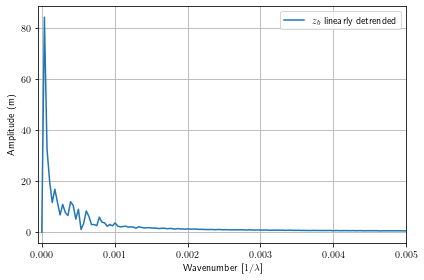

In [62]:
# Plot amplitude spectra
fig, ax = plt.subplots()

ax.plot(f ,np.sqrt(pxx), label='$z_b$ linearly detrended')
ax.set_ylabel('Amplitude'); 
ax.grid(True, which='both')
ax.legend()

ax.set_ylabel('Amplitude (m)'); 
ax.grid(True, which='both')
ax.set_xlabel('Wavenumber [$1/\lambda$]') # (m$^{-1}$)');
#ax.set_yscale('symlog')
ax.set_xlim(-.00005, 0.005)

fig.tight_layout()

#fig.savefig(fig_fp.format('01_zb_periodogram_.png'), dpi=300, bbox_inches='tight', facecolor='w')

In [63]:
print('Wavenumber of maximum amplitude: {} m '.format(1/f[np.sqrt(pxx).argmax()]))

Wavenumber of maximum amplitude: 27850.0 m 


Lets now define some bed pertrubations using: 

$$
z_{\rm b}^{\prime} = \sum_{k=1}^{10} A_{k} \sin \left( \frac{2 \pi}{k \bar H} x \right)
$$


In [64]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# SET PARAMETER VALUES
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
H_bar = 100.0         # [m] Mean ice-thickness
N     = 15            # [ ] How many harmonics to compute
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# SET INPUT DATA
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
x     = x_c.copy()   
dx    = x[1] - x[0]
M     = x.shape[0]
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# SET OUTPUT DATA
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
synth = np.zeros((M,N,6)) 
# DIM 0: x coordinate
# DIM 1: k harmnoics
# DIM 2: A/λ ratios
pxx   = np.zeros((M//2 + 1,N,6))
# DIM 0: wavenumbers
# DIM 1: k harmnoics
# DIM 2: A/λ ratios

In [65]:
%%time

# Itterate over the ratio of amplitude to wavelength
for i, ratio in enumerate(np.geomspace(10e-3, 10e-2, 6)):
    
    # Itterate over the harmonics
    for j, k in enumerate(np.arange(1,N+1,1)):
        λ = k*H_bar                 # [m] Wavelength 
        A = ratio * λ               # [m] Amplitude of k-th harmonic
        
        # Compute the k-th harmonic
        synth[:,j,i]  = A*np.sin(((2*np.pi)/λ)*x)
        
        # Compute the periodogram of the k-th harmonic
        f, pxx[:,j,i] = signal.periodogram(synth[:,j,i], fs=1/dx, scaling='spectrum')

        

CPU times: user 27.3 ms, sys: 2.12 ms, total: 29.4 ms
Wall time: 31.2 ms


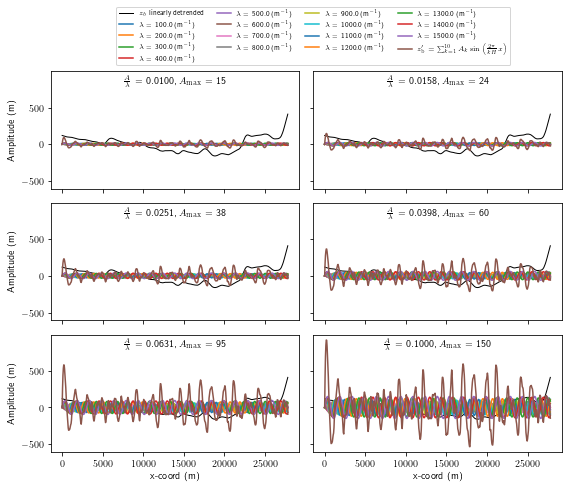

In [66]:
fig, ax = plt.subplots(3,2, figsize= (8, 6), 
                       sharey=True, sharex=True)

axes = ax.ravel()
for i, ratio in enumerate(np.geomspace(10e-3, 10e-2, 6)):
    
    if i == 0:
        axes[i].plot(x, z_b-trend, color='k', lw=1,
             label='$z_b$ linearly detrended')
    else:
        axes[i].plot(x, z_b-trend, color='k', lw=1)
        
    for j, k in enumerate(np.arange(1,N+1,1)):
        λ = k*H_bar # [m] Wavelength 
        
        if i == 0:
            axes[i].plot(x, synth[:,j,i],
                        label=r'$\lambda$ = {:6.1f} (m$^{{-1}}$)'.format(λ))
        else:
            axes[i].plot(x, synth[:,j,i])
            
    axes[i].text(0.5,0.9,
                 r'$\frac{{A}}{{\lambda}}$ = {:1.4f}, $A_{{\rm max}} =$ {:.0f}'.format(ratio,H_bar*N*ratio),
                 transform=axes[i].transAxes, horizontalalignment='center')
    
    if i == 0:  
        axes[i].plot(x, np.sum(synth[:,:,i], axis=1),
                    label=r'$z_{\rm b}^{\prime} = \sum_{k=1}^{10} A_{k} \sin \left( \frac{2 \pi}{k \bar H} x \right)$')
    else:
        axes[i].plot(x, np.sum(synth[:,:,i], axis=1))
        
    if i % 2 == 0: 
        axes[i].set_ylabel('Amplitude (m)')
    if i > 3:
        axes[i].set_xlabel('x-coord (m)')
        
fig.legend(loc='upper center', bbox_to_anchor= (0.55, 1.125), ncol=4,
            fontsize='x-small', borderaxespad=0, fancybox=True)

fig.tight_layout()
#fig.savefig('../plots/spectral/synthetic_waveforms.eps',bbox_inches='tight', facecolor='w')
#fig.savefig('../plots/spectral/synthetic_waveforms.png', bbox_inches='tight', facecolor='w', dpi = 300 )

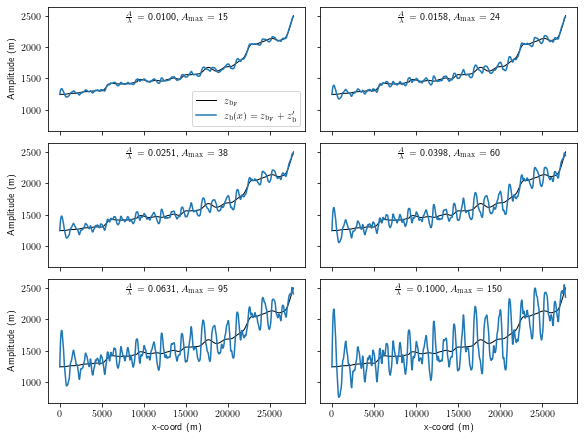

In [67]:
fig, ax = plt.subplots(3,2, figsize= (8, 6), 
                       sharey=True, sharex=True,
                       constrained_layout=True)

axes = ax.ravel()
for i, ratio in enumerate(np.geomspace(10e-3, 10e-2, 6)):
    
    axes[i].plot(x, z_b, color='k', lw=1,
                 label=r'$z_{\rm b_{\rm F}}$')

    axes[i].text(0.5,0.9,
                 r'$\frac{{A}}{{\lambda}}$ = {:1.4f}, $A_{{\rm max}} =$ {:.0f}'.format(ratio,H_bar*N*ratio),
                 transform=axes[i].transAxes, horizontalalignment='center')
    
    axes[i].plot(x, z_b+np.sum(synth[:,:,i], axis=1),
                label=r'$z_{\rm b}(x) = z_{\rm b_{\rm F}} + z_{\rm b}^{\prime}$')
    if i % 2 == 0: 
        axes[i].set_ylabel('Amplitude (m)')
    if i > 3:
        axes[i].set_xlabel('x-coord (m)')
        
axes[0].legend(loc=4)
# fig.savefig('../plots/spectral/pertrurbed_bedprof.eps',bbox_inches='tight', facecolor='w')
# fig.savefig('.../plots/spectral/pertrurbed_bedprof.png', bbox_inches='tight', facecolor='w', dpi = 300 )

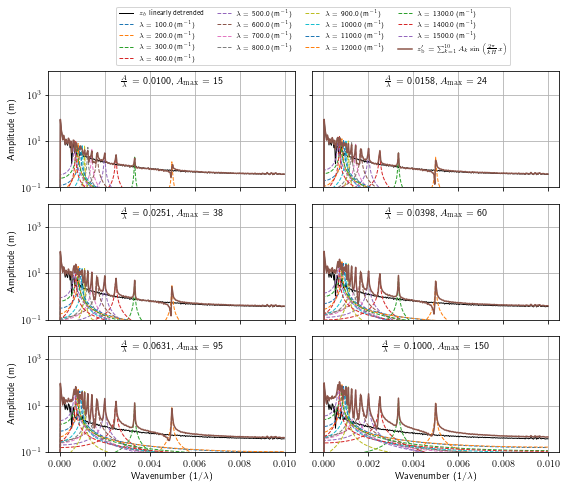

In [68]:
fig, ax = plt.subplots(3,2, figsize= (8, 6), 
                       sharey=True, sharex=True)

axes = ax.ravel()

bed_f, bed_pxx = signal.periodogram(z_b-trend, fs=1/dx, scaling='spectrum')

for i, ratio in enumerate(np.geomspace(10e-3, 10e-2, 6)):
    
    if i == 0:
        axes[i].plot(bed_f, np.sqrt(bed_pxx), color='k', lw=1,
             label='$z_b$ linearly detrended')
    else:
        axes[i].plot(bed_f, np.sqrt(bed_pxx), color='k', lw=1)
        
    for j, k in enumerate(np.arange(1,N+1,1)):
        λ = k*H_bar # [m] Wavelength 
        
        if i == 0:
            axes[i].plot(f, np.sqrt(pxx[:,j,i]), lw=1, ls = '--',
                        label=r'$\lambda$ = {:6.1f} (m$^{{-1}}$)'.format(λ))
        else:
            axes[i].plot(f, np.sqrt(pxx[:,j,i]), lw=1, ls = '--')
            
    axes[i].text(0.5,0.9,
                 r'$\frac{{A}}{{\lambda}}$ = {:1.4f}, $A_{{\rm max}} =$ {:.0f}'.format(ratio,H_bar*N*ratio),
                 transform=axes[i].transAxes, horizontalalignment='center')

    sum_f, sum_pxx = signal.periodogram((z_b-trend)+ np.sum(synth[:,:,i], axis=1), 
                                        fs=1/dx, scaling='spectrum')

    
    if i == 0:  
        axes[i].plot(sum_f, np.sqrt(sum_pxx),
                    label=r'$z_{\rm b}^{\prime} = \sum_{k=1}^{10} A_{k} \sin \left( \frac{2 \pi}{k \bar H} x \right)$')
    else:
        axes[i].plot(sum_f, np.sqrt(sum_pxx))
        
    if i % 2 == 0: 
        axes[i].set_ylabel('Amplitude (m)')
    if i > 3:
        axes[i].set_xlabel('Wavenumber (1/$\lambda$)')
    
    axes[i].grid(True, which='major')

axes[0].set_yscale('log')
axes[0].set_ylim(10e-2,10e3)
#axes[0].set_xlim(-.00005, 0.01)

fig.legend(loc='upper center', bbox_to_anchor= (0.55, 1.125), ncol=4,
            fontsize='x-small', borderaxespad=0, fancybox=True)


fig.tight_layout()
#fig.savefig('../plots/spectral/perturbed_spectograms_log.eps',bbox_inches='tight', facecolor='w')

#fig.savefig('../plots/spectral/perturbed_spectograms_log.png', bbox_inches='tight', facecolor='w', dpi = 300 )

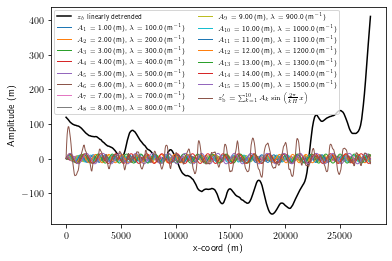

In [69]:
fig, ax = plt.subplots()

ax.plot(x_c, z_b-trend, c='k', label='$z_b$ linearly detrended')

summed = np.zeros(x_c.shape)
λ      = H_bar*np.arange(1,N+1,1.0)

sins   = np.zeros((x_c.shape[0],len(λ)))


for i in range(len(λ)):
    #A         = A_max * ((λ[i]/ λ[-1]))
    A = 10e-3*λ[i]
    sins[:,i] = A*np.sin(((2*np.pi)/λ[i])*x_c)
    ax.plot(x_c, sins[:,i], lw = 1.0, 
            label='$A_{{{}}}$ = {:5.2f} (m),  $\lambda$ = {:6.1f} (m$^{{-1}}$)'.format(i+1, A, λ[i]))

ax.plot(x_c, np.sum(sins, axis=1), lw = 1.0, label=r'$z_{\rm b}^{\prime} = \sum_{k=1}^{10} A_{k} \sin \left( \frac{2 \pi}{k \bar H} x \right)$')

ax.set_ylabel('Amplitude (m)'); 
ax.set_xlabel('x-coord (m)'); 

ax.legend(ncol=2, fontsize='x-small')

# fig.savefig(fig_fp.format('02_synthetic_signals.eps'), dpi=600, bbox_inches='tight', facecolor='w')

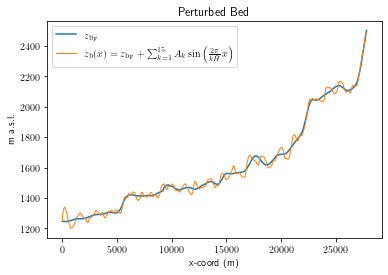

In [70]:
fig, ax = plt.subplots()

ax.plot(x_c, z_b, label=r'$z_{\rm b_{\rm F}}$')

# for i in range(len(λ)):
#     A = A_max * (λ[i]/ λ[-1])
#   ax.plot(x_c, z_b+sins[:,i], lw = 1.0, label='$A$ = {:5.2f} (m),  $\lambda$ = {:6.1f} (m$^{{-1}}$)'.format(A,λ[i]))
    
ax.plot(x_c, z_b+np.sum(sins, axis=1), lw = 1.0, label=r'$z_{\rm b}(x) = z_{\rm b_{\rm F}} + \sum_{k=1}^{15} A_{k} \sin \left( \frac{2 \pi}{k \tilde{H}} x \right)$')

ax.set_ylabel('m a.s.l.'); 
ax.set_xlabel('x-coord (m)'); 
ax.set_title( 'Perturbed Bed')

ax.legend()

# fig.savefig(fig_fp.format('03A_z_b_plus_signals.eps'), dpi=600, bbox_inches='tight', facecolor='w')
fig.savefig('/Users/andrewnolan/Desktop/test.png', dpi=600, bbox_inches='tight', facecolor='w')

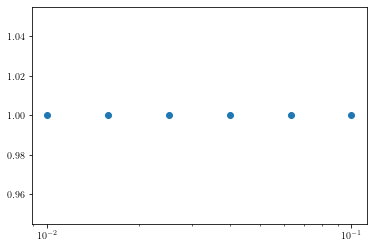

In [20]:
plt.plot(np.geomspace(1e-2, 1e-1,6), np.ones(6), 'o')
#plt.plot(np.linspace(10e-3, 10e-1,6), np.ones(6), 'o')

plt.xscale('log')

In [21]:
perb_fp = '/Users/andrewnolan/sfuvault/ELMERICE/Synthetic/Data/Topography/perturbed_10-harmonics_ratio-0.01.dat'
ref_fp  = '/Users/andrewnolan/sfuvault/ELMERICE/Synthetic/Data/Topography/REF_BedTopo.dat'

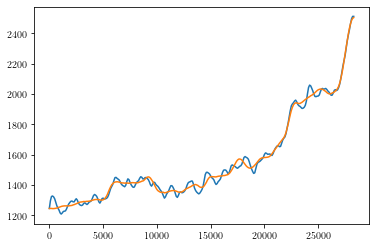

In [22]:
plt.plot(np.loadtxt(perb_fp)[:,0], np.loadtxt(perb_fp)[:,1])
plt.plot(np.loadtxt(ref_fp)[:,0], np.loadtxt(ref_fp)[:,1])

# Why is there an offset in the wavenumber on the periodograms?

In [ ]:
N

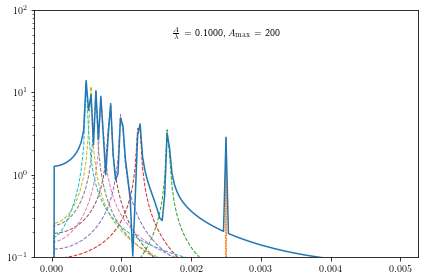

In [30]:
from scipy import interpolate

x_c = np.loadtxt('../Data/Topography/REF_SurfTopo.dat')[:,0]    # x-coordinate
z_s = np.loadtxt('../Data/Topography/REF_SurfTopo.dat')[:,1]    # surface elevation (m a.s.l.)
z_b = np.loadtxt('../Data/Topography/REF_BedTopo.dat')[:,1]     # bed evelation (m a.s.l.)

trend = np.polyval(np.polyfit(x_c, z_b, 1), x_c)

fig, ax = plt.subplots(1,1, figsize= (6, 4), 
                       sharey=True, sharex=True)

###########################################################################
# Reguaraly spacede data (100 m)
###########################################################################
bed_f, bed_pxx = signal.periodogram(z_b-trend, fs=1/dx, scaling='spectrum')

# ax.plot(bed_f, np.sqrt(bed_pxx), color='k', lw=1,
#      label='$z_b$ linearly detrended')

for j, k in enumerate(np.arange(1,N+1,1)):
    λ = k*H_bar # [m] Wavelength 

    ax.plot(f, np.sqrt(pxx[:,j,0]), lw=1, ls = '--',
                label=r'$\lambda$ = {:6.1f} (m$^{{-1}}$)'.format(λ))
    
ax.text(0.5,0.9,
             r'$\frac{{A}}{{\lambda}}$ = {:1.4f}, $A_{{\rm max}} =$ {:.0f}'.format(ratio,200*10*ratio),
             transform=ax.transAxes, horizontalalignment='center')  

sum_f, sum_pxx = signal.periodogram(np.sum(synth[:,:,0], axis=1), 
                                    fs=1/dx, scaling='spectrum')       
 
ax.plot(sum_f, np.sqrt(sum_pxx),
            label=r'$z_{\rm b}^{\prime} = \sum_{k=1}^{10} A_{k} \sin \left( \frac{2 \pi}{k \bar H} x \right)$')

ax.set_yscale('log')
ax.set_ylim(10e-2, 1e2)

fig.tight_layout()

fig.savefig('../plots/spectral/offset_test.png', bbox_inches='tight', facecolor='w', dpi = 300 )

143
143


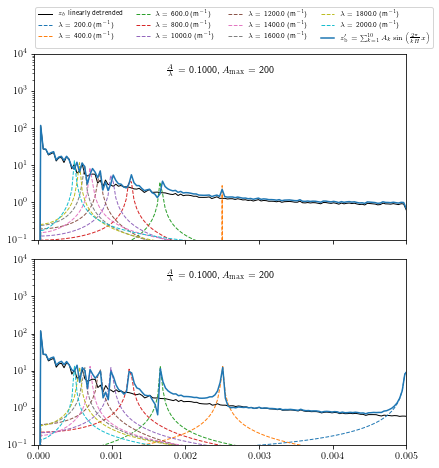

In [31]:
from scipy import interpolate

x_c = np.loadtxt('../Data/Topography/REF_SurfTopo.dat')[:,0]    # x-coordinate
z_s = np.loadtxt('../Data/Topography/REF_SurfTopo.dat')[:,1]    # surface elevation (m a.s.l.)
z_b = np.loadtxt('../Data/Topography/REF_BedTopo.dat')[:,1]     # bed evelation (m a.s.l.)

trend = np.polyval(np.polyfit(x_c, z_b, 1), x_c)

fig, ax = plt.subplots(2,1, figsize= (6, 6), 
                       sharey=True, sharex=True)

###########################################################################
# Reguaraly spacede data (100 m)
###########################################################################
bed_f, bed_pxx = signal.periodogram(z_b-trend, fs=1/dx, scaling='spectrum')

ax[0].plot(bed_f, np.sqrt(bed_pxx), color='k', lw=1,
     label='$z_b$ linearly detrended')

for j, k in enumerate(np.arange(1,N+1,1)):
    λ = k*H_bar # [m] Wavelength 

    ax[0].plot(f, np.sqrt(pxx[:,j,0]), lw=1, ls = '--',
                label=r'$\lambda$ = {:6.1f} (m$^{{-1}}$)'.format(λ))
    
ax[0].text(0.5,0.9,
             r'$\frac{{A}}{{\lambda}}$ = {:1.4f}, $A_{{\rm max}} =$ {:.0f}'.format(ratio,200*10*ratio),
             transform=ax[0].transAxes, horizontalalignment='center')  

sum_f, sum_pxx = signal.periodogram((z_b-trend)+ np.sum(synth[:,:,0], axis=1), 
                                    fs=1/dx, scaling='spectrum')       
 
ax[0].plot(sum_f, np.sqrt(sum_pxx),
            label=r'$z_{\rm b}^{\prime} = \sum_{k=1}^{10} A_{k} \sin \left( \frac{2 \pi}{k \bar H} x \right)$')

print(len(f))
###########################################################################
# Finer resolution data (10 m)
###########################################################################
func = interpolate.interp1d(x_c, z_b)

x_c = np.linspace(0,x_c[-1],2831)
z_b = func(x_c)


dx = x_c[1] - x_c[0]


trend = np.polyval(np.polyfit(x_c, z_b, 1), x_c)

bed_f, bed_pxx = signal.periodogram(z_b-trend, fs=1/dx, scaling='spectrum')

ax[1].plot(bed_f, np.sqrt(bed_pxx), color='k', lw=1)


interp_synth = np.zeros_like(x_c)
for j, k in enumerate(np.arange(1,N+1,1)):
    λ = k*H_bar # [m] Wavelength 
    
    # Compute the k-th harmonic
    k_th_interp_synth = A*np.sin(((2*np.pi)/λ)*x_c)
    
    interp_synth += k_th_interp_synth.copy()
    # Compute the periodogram of the k-th harmonic
    f_interp, intep_pxx = signal.periodogram(k_th_interp_synth, fs=1/dx, scaling='spectrum')

    ax[1].plot(f_interp, np.sqrt(intep_pxx), lw=1, ls = '--')

ax[1].text(0.5,0.9,
             r'$\frac{{A}}{{\lambda}}$ = {:1.4f}, $A_{{\rm max}} =$ {:.0f}'.format(ratio,200*10*ratio),
             transform=ax[1].transAxes, horizontalalignment='center')  

sum_f, sum_pxx = signal.periodogram((z_b-trend)+ interp_synth, 
                                    fs=1/dx, scaling='spectrum')       
 
ax[1].plot(sum_f, np.sqrt(sum_pxx))


print(len(f))

# for i, ratio in enumerate([100, 10]):
#     if i == 0:
#         axes[i].plot(bed_f, np.sqrt(bed_pxx), color='k', lw=1,
#              label='$z_b$ linearly detrended')
        
#     else:
#         axes[i].plot(bed_f, np.sqrt(bed_pxx), color='k', lw=1)
        
#     for j, k in enumerate(np.arange(1,N+1,1)):
#         λ = k*H_bar # [m] Wavelength 
        
#         if i == 0:
#             axes[i].plot(f, np.sqrt(pxx[:,j,i]), lw=1, ls = '--',
#                         label=r'$\lambda$ = {:6.1f} (m$^{{-1}}$)'.format(λ))
#         else:
#             axes[i].plot(f, np.sqrt(pxx[:,j,i]), lw=1, ls = '--')
            
#     axes[i].text(0.5,0.9,
#                  r'$\frac{{A}}{{\lambda}}$ = {:1.4f}, $A_{{\rm max}} =$ {:.0f}'.format(ratio,200*10*ratio),
#                  transform=axes[i].transAxes, horizontalalignment='center')

#     sum_f, sum_pxx = signal.periodogram((z_b-trend)+ np.sum(synth[:,:,i], axis=1), 
#                                         fs=1/dx, scaling='spectrum')

    
#     if i == 0:  
#         axes[i].plot(sum_f, np.sqrt(sum_pxx),
#                     label=r'$z_{\rm b}^{\prime} = \sum_{k=1}^{10} A_{k} \sin \left( \frac{2 \pi}{k \bar H} x \right)$')
#     else:
#         axes[i].plot(sum_f, np.sqrt(sum_pxx))
        
#     if i % 2 == 0: 
#         axes[i].set_ylabel('Amplitude (m)')
#     if i > 3:
#         axes[i].set_xlabel('Wavenumber (1/$\lambda$)')
    
#     axes[i].grid(True, which='major')

ax[1].set_yscale('log')
ax[1].set_ylim(10e-2,10e3)
ax[1].set_xlim(-.00005, 0.005)

fig.legend(loc='upper center', bbox_to_anchor= (0.55, 1.075), ncol=4,
            fontsize='x-small', borderaxespad=0, fancybox=True)


fig.tight_layout()

fig.savefig('../plots/spectral/test.png', bbox_inches='tight', facecolor='w', dpi = 300 )


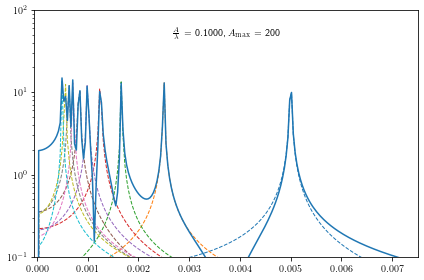

In [38]:
fig, ax = plt.subplots(1,1, figsize= (6, 4), 
                       sharey=True, sharex=True)

###########################################################################
# Reguaraly spacede data (100 m)
###########################################################################

# ax.plot(bed_f, np.sqrt(bed_pxx), color='k', lw=1,
#      label='$z_b$ linearly detrended')

interp_synth = np.zeros_like(x_c)

for j, k in enumerate(np.arange(1,N+1,1)):
    λ = k*H_bar # [m] Wavelength 
    
    # Compute the k-th harmonic
    k_th_interp_synth = A*np.sin(((2*np.pi)/λ)*x_c)
    
    interp_synth += k_th_interp_synth.copy()
    # Compute the periodogram of the k-th harmonic
    f_interp, intep_pxx = signal.periodogram(k_th_interp_synth, fs=1/dx, scaling='spectrum')

    ax.plot(f_interp, np.sqrt(intep_pxx), lw=1, ls = '--')

ax.text(0.5,0.9,
             r'$\frac{{A}}{{\lambda}}$ = {:1.4f}, $A_{{\rm max}} =$ {:.0f}'.format(ratio,200*10*ratio),
             transform=ax.transAxes, horizontalalignment='center')  

sum_f, sum_pxx = signal.periodogram(interp_synth, 
                                    fs=1/dx, scaling='spectrum')       
 
ax.plot(sum_f, np.sqrt(sum_pxx),
            label=r'$z_{\rm b}^{\prime} = \sum_{k=1}^{10} A_{k} \sin \left( \frac{2 \pi}{k \bar H} x \right)$')

ax.set_yscale('log')
ax.set_ylim(10e-2, 1e2)
ax.set_xlim(-.00005, 0.0075)

fig.tight_layout()

fig.savefig('../plots/spectral/offset_test_interp.png', bbox_inches='tight', facecolor='w', dpi = 300 )

In [71]:
3157.07 / 60.

52.61783333333334

In [74]:
5560 / 10

556.0